In [22]:
# Importanweisungen

import numpy as num
import scipy as sci
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.axes as axes
import math
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp 
unv=unp.nominal_values
usd=unp.std_devs

In [23]:
# Konstanten fuer einheitliche Darstellung

fig_size = (10, 6)
fig_legendsize = 14
fig_labelsize = 12

In [24]:
# allgemeine Fitfunktionen

def linear(x,m): # lineare Funktion mit f(x) = m * x 
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * num.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):

    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(num.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = num.array(error)
    return pfit_curvefit, perr_curvefit 

# usage zB:
# pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0

In [25]:
# gibt Daten fuer LaTeX bereitgestellt aus

def latex_printValue(val, file):
    f = open('data/%s.txt' % file, 'w')
    f.write(str(val).replace('/', ''))

In [26]:
# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]
# Wasser eigenschaften: https://webbook.nist.gov/cgi/inchi/InChI%3D1S/H2O/h1H2
# https://www.engineeringtoolbox.com/water-thermal-properties-d_162.html

c = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin 

In [27]:
# import der messwerte

unc_freq = 0.03 / num.sqrt(3) # digital etwa 0.03 Hz
unc_x = 0.0001 / num.sqrt(3) # digital Position

con = {}
for i in range(0,50):
    con[i] = lambda s: float(s if len(s) > 0 else 0)

data = num.loadtxt("messung/reibung.txt", skiprows = 2, usecols = (0, 1, 2, 9), delimiter = "\t", converters = con)
fft = [unp.uarray(data[:,0], unc_freq), data[:,1]] # erste Spalte freq von FFT, zweite Spalte FFT Werte
reibung = [unp.uarray(data[:,2], unc_t50), unp.uarray(data[:, 3], unc_x)] # dritte Spalte Zeit der Messung in s, zehnte Spalte position in m

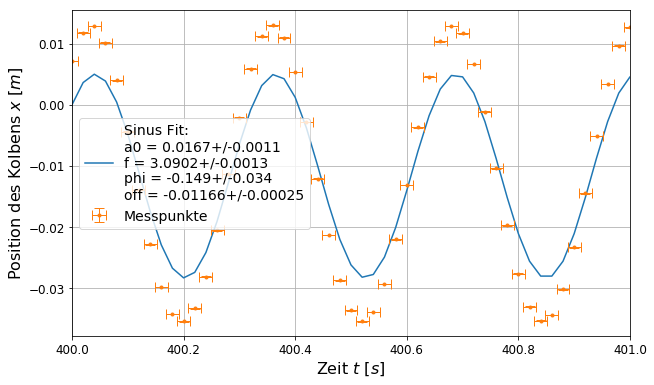

In [33]:
# diagramm: Position

fig=plt.figure(figsize=fig_size)

xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 395 and s[0] <= 405, num.transpose(reibung))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), cyclicOff, yerr = usd(ydata), p0 = [0.02, 2 * math.pi * 3.0903, 0.7, -0.01165])
p = unp.uarray(pfit, perr)
p[1] /= 2 * math.pi
f_Fit = p[1] # gefittete Frequenz
latex_printValue(f_Fit, "frequenz_Fit_Hz")
plt.plot(unv(xdata), cyclicOff(unv(xdata), *pfit), label='Sinus Fit:\na0 = %s\nf = %s\nphi = %s\noff = %s' % tuple(p))

r = num.transpose(list(filter(lambda s: s[0] >= 399 and s[0] <= 402, num.transpose(reibung))))
plt.errorbar(unv(r[0]),unv(r[1]),usd(r[1]),usd(r[0]),fmt='.', capsize=5, linewidth=1, label='Messpunkte')

plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Zeit $t$ [$s$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Position des Kolbens $x$ [$m$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/Position.pdf")
plt.show()

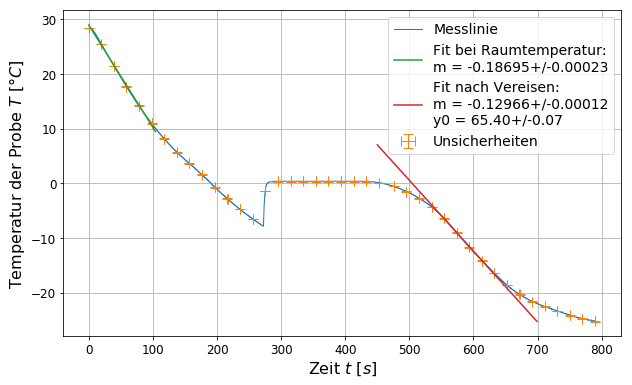

In [29]:
# diagramm: abkuehlen

fig=plt.figure(figsize=fig_size)


xdata, ydata = kalt
plt.plot(unv(xdata),unv(ydata), linewidth=1, label='Messlinie')

xdata, ydata = kalt[:, 0::196]
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label='Unsicherheiten')

xdata, ydata = num.transpose(list(filter(lambda s: s[1] >= 10 and s[1] <= 30, num.transpose(kalt))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [-0.1, 30])
p = unp.uarray(pfit, perr)
dT_kalt = p[0]
latex_printValue(dT_kalt, "dT_raumtemp_Ks-1")
plt.plot(unv(xdata), gerade(unv(xdata), *pfit), label='Fit bei Raumtemperatur:\nm = %s' % (p[0]))

xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 550 and s[0] <= 630, num.transpose(kalt))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [-0.1, 30])
p = unp.uarray(pfit, perr)
dT_frier = p[0]
T0_frier = p[1]
plt.plot(num.arange(450, 700), gerade(num.arange(450, 700), *pfit), label='Fit nach Vereisen:\nm = %s\ny0 = %s' % tuple(p))

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Zeit $t$ [$s$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Temperatur der Probe $T$ [$°C$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/kalt_machen.pdf")
plt.show()

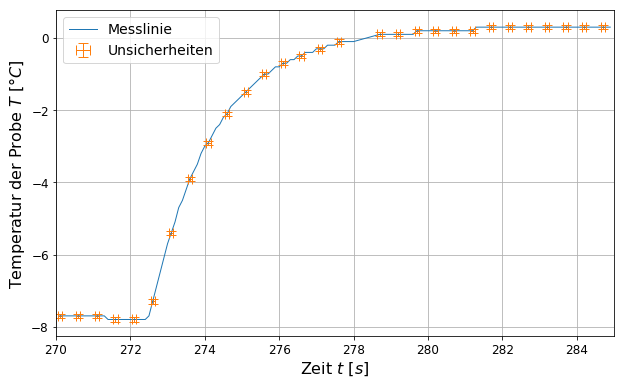

In [30]:
# diagramm: sprung

fig=plt.figure(figsize=fig_size)



xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 270 and s[0] <= 285, num.transpose(kalt))))
plt.plot(unv(xdata),unv(ydata), linewidth=1, label='Messlinie')

xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 270 and s[0] <= 285, num.transpose(kalt))))[:, 0::5]
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label='Unsicherheiten')

kalt_tsprung = unc.ufloat(272.6, 5 * unc_t20)

plt.xlim(270,285)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Zeit $t$ [$s$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Temperatur der Probe $T$ [$°C$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/kalt_sprung.pdf")
plt.show()

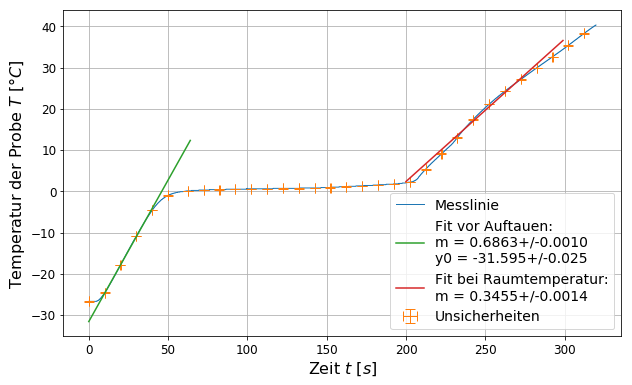

In [31]:
# diagramm: abkuehlen

fig=plt.figure(figsize=fig_size)

#pfit, perr = fit_curvefit(unv(xdata), unv(ydata), cyclicOff, yerr = usd(ydata), p0 = [0.02, 2 * math.pi * 3.0903, 0.7, -0.01165])
#p = unp.uarray(pfit, perr)
#p[1] /= 2 * math.pi
#f_Fit = p[1] # gefittete Frequenz
#latex_printValue(f_Fit, "frequenz_Fit_Hz")

xdata, ydata = warm
plt.plot(unv(xdata),unv(ydata), linewidth=1, label='Messlinie')

xdata, ydata = warm[:, 0::100]
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label='Unsicherheiten')

xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 10 and s[0] <= 40, num.transpose(warm))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [0.1, -30])
p = unp.uarray(pfit, perr)
dT_schmelz = p[0]
T0_schmelz = p[1]
plt.plot(num.arange(0, 65), gerade(num.arange(0, 65), *pfit), label='Fit vor Auftauen:\nm = %s\ny0 = %s' % tuple(p))

xdata, ydata = num.transpose(list(filter(lambda s: s[1] >= 10 and s[1] <= 30, num.transpose(warm))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [0.1, -30])
p = unp.uarray(pfit, perr)
dT_warm = p[0]
plt.plot(num.arange(200, 300), gerade(num.arange(200, 300), *pfit), label='Fit bei Raumtemperatur:\nm = %s' % dT_warm)

warm_tsprung = unc.ufloat(200, 5/num.sqrt(6))

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Zeit $t$ [$s$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Temperatur der Probe $T$ [$°C$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/warm_machen.pdf")
plt.show()

In [32]:
# Rechnung

